# Generalization performance of the GNN model to other conditions

In [6]:
!pip install rdkit

In [7]:
!pip install torch_geometric

In [8]:
!pip install mordred

In [9]:
# Utilities
from tqdm.notebook import tqdm
# Scientific python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams["text.usetex"] = False
from matplotlib.colors import Normalize
import sklearn
from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from torch_geometric.nn.pool import global_add_pool
from torch.utils.data import TensorDataset
from torch_geometric.utils import scatter
from torch_geometric.data import Batch
from torch.utils.data import Dataset

# RDKit
import rdkit
from rdkit import Chem
import mordred
from mordred.Polarizability import APol, BPol
from mordred.TopoPSA import TopoPSA
from rdkit.Chem import rdMolDescriptors
print('Pytorch version:',torch.__version__)
print('Pytorch Geometric version:',torch_geometric.__version__)
print('RDKit version:', rdkit.__version__)
print('Mordred version:', mordred.__version__)
tqdm.pandas()

Pytorch version: 2.1.0+cu121
Pytorch Geometric version: 2.5.0
RDKit version: 2023.09.5
Mordred version: 1.2.0


## Load data

In [10]:
df = pd.read_csv('data_cleaned.csv')

since we will analyze the performance of the model when generalizign to other DES, we will create different train/test splits for every case. Let's then eliminate the original Split column from the dataframe

In [11]:
df = df.drop('Split', axis=1)

## Add SMILES

In [12]:
df_hba = pd.read_csv('HBA_smiles.csv')
df_hbd = pd.read_csv('HBD_smiles.csv')

In [13]:
df['HBA_SMILES'] = df['HBA name'].map(df_hba.set_index('Short')['SMILES'])
df['HBD_SMILES'] = df['HBD name'].map(df_hbd.set_index('Short')['SMILES'])

## Create molecules

In [14]:
df['mol_hba'] = df['HBA_SMILES'].apply(Chem.MolFromSmiles)
df['mol_hbd'] = df['HBD_SMILES'].apply(Chem.MolFromSmiles)

## Compute molecular descriptors

### Atomic polarizability

In [15]:
ap_fun = APol()
df['ap_hba'] = df['mol_hba'].apply(ap_fun)
df['ap_hbd'] = df['mol_hbd'].apply(ap_fun)

### Bond polarizability

In [16]:
bp_fun = BPol()
df['bp_hba'] = df['mol_hba'].apply(bp_fun)
df['bp_hbd'] = df['mol_hbd'].apply(bp_fun)

### Topological polar surface area

In [17]:
topopsa_fun = TopoPSA()
df['topopsa_hba'] = df['mol_hba'].apply(topopsa_fun)
df['topopsa_hbd'] = df['mol_hbd'].apply(topopsa_fun)

### Intra-molecular hydrogen-bonding sites

In [18]:
def get_hb_sites(mol):
  return min(rdMolDescriptors.CalcNumHBA(mol), rdMolDescriptors.CalcNumHBD(mol))

df['hb_hba'] = df['mol_hba'].apply(get_hb_sites)
df['hb_hbd'] = df['mol_hbd'].apply(get_hb_sites)

### Inter-molecular hydrogen bonding sites

In [19]:
def get_inter_hb_sites(row):
    mol1 = row['mol_hba']
    mol2 = row['mol_hbd']
    return min(rdMolDescriptors.CalcNumHBA(mol1), rdMolDescriptors.CalcNumHBD(mol2)) + \
           min(rdMolDescriptors.CalcNumHBA(mol2), rdMolDescriptors.CalcNumHBD(mol1))


df['inter_hb'] = df.apply(get_inter_hb_sites, axis=1)

## Utilities for creating graphs

In [20]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

### Atomic features

In [21]:
possible_atom_list = [
    'C',
    'O',
    'N',
    'Cl',
    'Br',
    'P',
    ]
possible_hybridization = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3
    ]
possible_num_bonds = [
    0,
    1,
    2,
    3,
    4
    ]
possible_formal_charge = [
    0,
    1,
    -1
    ]
possible_num_Hs  = [
    0,
    1,
    2,
    3
    ]

def atom_features(atom):
    '''
    Get atom features
    '''
    Symbol       = atom.GetSymbol()
    Type_atom     = one_of_k_encoding(Symbol, possible_atom_list)
    Ring_atom     = [atom.IsInRing()]
    Aromaticity   = [atom.GetIsAromatic()]
    Hybridization = one_of_k_encoding(atom.GetHybridization(), possible_hybridization)
    Bonds_atom    = one_of_k_encoding(len(atom.GetNeighbors()), possible_num_bonds)
    Formal_charge = one_of_k_encoding(atom.GetFormalCharge(), possible_formal_charge)
    num_Hs        = one_of_k_encoding(atom.GetTotalNumHs(), possible_num_Hs)

    results = Type_atom + Ring_atom + Aromaticity + Hybridization + Bonds_atom +  \
      Formal_charge + num_Hs
    return np.array(results).astype(np.float32)

### Bond features

In [22]:
def get_bond_pair(mol):
    bonds = mol.GetBonds()
    res = [[], []]
    for bond in bonds:
        res[0] += [bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]
        res[1] += [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]
    return res

def bond_features(bond):
    bt = bond.GetBondType()
    # Features
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()]
    return np.array(bond_feats).astype(np.float32)

## Utilities

In [23]:
def n_atom_features():
    atom = Chem.MolFromSmiles('CC').GetAtomWithIdx(0)
    return len(atom_features(atom))

def n_bond_features():
    bond = Chem.MolFromSmiles('CC').GetBondWithIdx(0)
    return len(bond_features(bond))

def sys2graph(df, mol_column_1, mol_column_2, target, single_system=False):
    """
    Constructs graph representations of binary molecular systems.

    Parameters:
    df (pd.DataFrame): Input dataframe.
    mol_column_1 (str): Column name for the first component.
    mol_column_2 (str): Column name for the second component.
    target (str): Column name for the target variable.
    single_system (bool, optional): Whether to treat the dataframe as a single system.

    Returns:
    list: A list of graph objects.
    """
    def process_component(comp):
        """Processes a single component to extract edge attributes and indices."""
        edge_attr = []
        edge_index = get_bond_pair(comp)
        for bond in comp.GetBonds():
            edge_attr.extend([bond_features(bond)] * 2)
        return edge_attr, edge_index

    def info2graph(node_feat, edge_indx, edge_attr, y):
        """Creates graph for a component including the intra- and inter-molecular information"""
        nodes_info = torch.tensor(np.array(node_feat), dtype=torch.float32)
        edges_indx = torch.tensor(np.array(edge_indx), dtype=torch.long)
        edges_info = torch.tensor(np.array(edge_attr), dtype=torch.float32)
        graph = Data(x=nodes_info, edge_index=edges_indx, edge_attr=edges_info)
        graph.y = torch.tensor(y, dtype=torch.float)
        return graph

    def create_graph_indiv(c1, c2, y_val):
        """Helper function to create individual graphs."""
        atoms_c1 = c1.GetAtoms()
        atoms_c2 = c2.GetAtoms()
        node_features_c1 = [atom_features(atom) for atom in atoms_c1]
        node_features_c2 = [atom_features(atom) for atom in atoms_c2]

        edge_attr_c1, edge_index_c1 = process_component(c1)
        edge_attr_c2, edge_index_c2 = process_component(c2)

        # Info to graphs
        graph_c1 = info2graph(node_features_c1, edge_index_c1, edge_attr_c1, y_val)
        graph_c2 = info2graph(node_features_c2, edge_index_c2, edge_attr_c2, y_val)

        return graph_c1, graph_c2

    def create_graphs_from_row(row, mol_column_1, mol_column_2, target):
        graph_c1, graph_c2 = create_graph_indiv(row[mol_column_1], row[mol_column_2], row[target])

        # Append extra information to the graphs
        for graph in [graph_c1, graph_c2]:
            graph.Temp = row['T_norm']
            graph.P = row['P_norm']
            graph.mol_x = row['r_HBA_norm'] if graph == graph_c1 else row['r_HBD_norm']
            graph.ap = row['ap_hba_norm'] if graph == graph_c1 else row['ap_hbd_norm']
            graph.bp = row['bp_hba_norm'] if graph == graph_c1 else row['bp_hbd_norm']
            graph.topopsa = row['topopsa_hba_norm'] if graph == graph_c1 else row['topopsa_hbd_norm']
            graph.hb = row['hb_hba_norm'] if graph == graph_c1 else row['hb_hbd_norm']
            graph.inter_hb = row['inter_hb_norm']

        return graph_c1, graph_c2

    # Main function logic
    graphs_c1, graphs_c2 = zip(*df.apply(create_graphs_from_row, axis=1, args=(mol_column_1, mol_column_2, target)))
    return graphs_c1, graphs_c2

## Graph Neural Network

In [24]:
class MPNNconv(nn.Module):
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats,
                 edge_hidden_feats=32, num_step_message_passing=1):
        super(MPNNconv, self).__init__()

        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU()
        )

        self.num_step_message_passing = num_step_message_passing

        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(),
            nn.Linear(edge_hidden_feats, node_out_feats*node_out_feats)
        )
        self.gnn_layer = gnn.NNConv(
            node_out_feats,
            node_out_feats,
            edge_network,
            aggr='add'
        )
        self.gru = nn.GRU(node_out_feats, node_out_feats)

    def reset_parameters(self):
        self.project_node_feats[0].reset_parameters()
        self.gnn_layer.reset_parameters()
        for layer in self.gnn_layer.edge_func:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()
        self.gru.reset_parameters()

    def forward(self, system_graph):

        node_feats = system_graph.x
        edge_index = system_graph.edge_index
        edge_feats = system_graph.edge_attr
        node_feats = self.project_node_feats(node_feats) # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            if torch.cuda.is_available():
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor).cuda(),
                                                   edge_index=edge_index.type(torch.LongTensor).cuda(),
                                                   edge_attr=edge_feats.type(torch.FloatTensor).cuda()))
            else:
                node_feats = F.relu(self.gnn_layer(x=node_feats.type(torch.FloatTensor),
                                                   edge_index=edge_index.type(torch.LongTensor),
                                                   edge_attr=edge_feats.type(torch.FloatTensor)))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = node_feats.squeeze(0)
        return node_feats

class EdgeModel(torch.nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in*2 + e_in + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.edge_mlp = nn.Sequential(*layers)

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr, u[batch]], axis=1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self, v_in, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(v_in + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.node_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0), reduce='sum')
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp(out)

class GlobalModel(torch.nn.Module):
    def __init__(self, u_in, hidden_dim):
        super().__init__()

        layers = [nn.Linear(hidden_dim + hidden_dim + u_in, hidden_dim),
                  nn.ReLU(),
                  nn.Linear(hidden_dim, hidden_dim)]

        self.global_mlp = nn.Sequential(*layers)

    def forward(self, x, edge_index, edge_attr, u, batch):
        node_aggregate = scatter(x, batch, dim=0, reduce='sum')
        edge_aggregate = scatter(edge_attr, batch[edge_index[1]], dim=0, reduce='sum')
        out = torch.cat([u, node_aggregate, edge_aggregate], dim=1)
        return self.global_mlp(out)

class GHGNN(nn.Module):
    def __init__(self, v_in, e_in, u_in, hidden_dim, n_extra_inputs):
        super(GHGNN, self).__init__()
        self.graphnet1 = gnn.MetaLayer(EdgeModel(v_in, e_in, u_in, hidden_dim),
                                      NodeModel(v_in, u_in, hidden_dim),
                                      GlobalModel(u_in, hidden_dim))
        self.graphnet2 = gnn.MetaLayer(EdgeModel(hidden_dim, hidden_dim, hidden_dim, hidden_dim),
                                      NodeModel(hidden_dim, hidden_dim, hidden_dim),
                                      GlobalModel(hidden_dim, hidden_dim))

        self.gnorm1 = gnn.GraphNorm(hidden_dim)
        self.gnorm2 = gnn.GraphNorm(hidden_dim)

        self.pool = global_add_pool

        self.global_conv1 = MPNNconv(node_in_feats=hidden_dim*2,
                                     edge_in_feats=1,
                                     node_out_feats=hidden_dim*2)

        # MLP
        self.mlp1 = nn.Linear(hidden_dim*4 + n_extra_inputs, hidden_dim)
        self.mlp2 = nn.Linear(hidden_dim, hidden_dim)
        self.mlp3 = nn.Linear(hidden_dim, 1)

    def generate_sys_graph(self, x, edge_attr, batch_size, n_mols=2):

        src = np.arange(batch_size)
        dst = np.arange(batch_size, n_mols*batch_size)

        self_connection = np.arange(n_mols*batch_size)

        # Biderectional connections (between each molecule in the system)
        # and self-connection
        one_way = np.concatenate((src, dst, self_connection))
        other_way = np.concatenate((dst, src, self_connection))
        edge_index = torch.tensor([list(one_way),
                                   list(other_way)], dtype=torch.long)
        sys_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return sys_graph

    def forward(self, c1, c2):
        # ---- Atomic polarizability
        ap1 = c1.ap.reshape(-1,1)
        ap2 = c2.ap.reshape(-1,1)

        # ---- Bond polarizability
        bp1 = c1.bp.reshape(-1,1)
        bp2 = c2.bp.reshape(-1,1)

        # -- Polarity via topological polar surface area
        topopsa1 = c1.topopsa.reshape(-1,1)
        topopsa2 = c2.topopsa.reshape(-1,1)

        # -- Hydrogen-bond acidity and basicity
        intra_hb1 = c1.inter_hb
        intra_hb2 = c2.inter_hb

        u1 = torch.cat((ap1,bp1,topopsa1), axis=1) # Molecular descriptors molecule 1
        u2 = torch.cat((ap2,bp2,topopsa2), axis=1) # Molecular descriptors molecule 2

        # Molecule 1 GraphNet
        x1, edge_attr1, u1 = self.graphnet1(c1.x, c1.edge_index, c1.edge_attr, u1, c1.batch)
        x1 = self.gnorm1(x1, c1.batch)
        x1, edge_attr1, u1 = self.graphnet2(x1, c1.edge_index, edge_attr1, u1, c1.batch)
        x1 = self.gnorm2(x1, c1.batch)
        xg1 = self.pool(x1, c1.batch)

        # Molecule 2 GraphNet
        x2, edge_attr2, u2 = self.graphnet1(c2.x, c2.edge_index, c2.edge_attr, u2, c2.batch)
        x2 = self.gnorm1(x2, c2.batch)
        x2, edge_attr2, u2 = self.graphnet2(x2, c2.edge_index, edge_attr2, u2, c2.batch)
        x2 = self.gnorm2(x2, c2.batch)
        xg2 = self.pool(x2, c2.batch)

        batch_size = c1.y.shape[0]

        # Intermolecular descriptors
        # -- Hydrogen bonding
        inter_hb  = c1.inter_hb
        # Construct binary system graph
        node_feat = torch.cat((
            torch.cat((xg1, u1), axis=1),
            torch.cat((xg2, u2), axis=1)),axis=0)
        edge_feat = torch.cat((inter_hb.repeat(2),
                               intra_hb1,
                               intra_hb2)).unsqueeze(1)
        binary_sys_graph = self.generate_sys_graph(x=node_feat,
                                                   edge_attr=edge_feat,
                                                   batch_size=batch_size)
        xg = self.global_conv1(binary_sys_graph)


        xg = torch.cat((xg[0:len(xg)//2,:], xg[len(xg)//2:,:]), axis=1)

        T = torch.reshape(c1.Temp,(-1,1))
        P = torch.reshape(c2.P,(-1,1))
        x1 = torch.reshape(c1.mol_x,(-1,1))
        x2 = torch.reshape(c2.mol_x,(-1,1))

        ExtraVar = torch.cat((T,P,x1,x2),1)
        x = torch.cat((xg,ExtraVar),1)
        x = F.sigmoid(self.mlp1(x))
        x = F.sigmoid(self.mlp2(x))
        x = self.mlp3(x)
        return x

class AccumulationMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0.0
        self.sum = 0.0
        self.count = 0.0
        self.avg = 0.0

    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
class PairDataset(Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
    def __getitem__(self, idx):
        return self.datasetA[idx], self.datasetB[idx]
    def __len__(self):
        return len(self.datasetA)

def collate(data_list):
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    return batchA, batchB

def get_dataloader_pairs(df, graphs_c1, graphs_c2, batch_size, shuffle=False, drop_last=False):

    g1s = df[graphs_c1].tolist()
    g2s  = df[graphs_c2].tolist()

    pair_dataset = PairDataset(g1s, g2s)
    data_loader  = torch.utils.data.DataLoader(pair_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, collate_fn=collate)

    return data_loader

In [26]:
def train(model, device, dataloader, optimizer, loss_fn):
    """
    Trains the model.

    Parameters:
    model: The neural network model to train.
    device: The device (CPU or CUDA) to use for training.
    dataloader: DataLoader object for the training data.
    optimizer: Optimizer for the training process.
    loss_fn: Loss function used for training.

    Returns:
    Average loss over the training dataset.
    """
    model.train()
    loss_accum = AccumulationMeter()
    for batch_c1, batch_c2 in dataloader:
        y =  batch_c1.y
        X1 = batch_c1
        X2 = batch_c2
        X1, X2, y = X1.to(device), X2.to(device), y.to(device)

        # Model prediction and loss calculation
        y_hat = model(X1, X2)
        loss = loss_fn(y_hat, y.reshape(-1,1))
        loss_accum.update(loss.item(), y.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_accum.avg

def test(model, device, dataloader, loss_fn):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for batch_c1, batch_c2 in dataloader:
            y =  batch_c1.y
            X1 = batch_c1
            X2 = batch_c2
            X1, X2, y = X1.to(device), X2.to(device), y.to(device)

            # Model prediction and loss calculation
            y_hat = model(X1, X2)
            loss = loss_fn(y_hat, y.reshape(-1,1))
            loss_accum.update(loss.item(), y.size(0))

    return loss_accum.avg

In [27]:
def parity_plots(y_train, y_train_hat, y_test, y_test_hat, color_vals=None):

  metrics = [r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error]
  metric_names = ['R2', 'MAPE', 'MAE', 'MSE']

  metrics_dict = {}
  for split, (y_true, y_pred) in zip(['train', 'test'], [(y_train, y_train_hat), (y_test, y_test_hat)]):
    metrics_dict[split] = {}
    for name, metric in zip(metric_names, metrics):
      metrics_dict[split][name] = metric(y_true, y_pred)

  metrics_test = (r'$R^2 = {:.2f} $' '\n' r'$MAPE = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$MSE = {:.2f}$' .format(
      metrics_dict['test']['R2'],
      metrics_dict['test']['MAPE']*100,
      metrics_dict['test']['MAE'],
      metrics_dict['test']['MSE']**0.5))

  fig , ax2 = plt.subplots(figsize=(5,5))
  ax2.set_xlabel(r'$ln(x^{exp}_{CO_2}) $')
  ax2.set_ylabel(r'$ln(x^{pred}_{CO_2}) $')
  ax2.set_ylim([-7.5,-0.5])
  ax2.set_xlim([-7.5,-0.5])
  ax2.text(-6.8,-2.5, metrics_test, fontsize=10)
  ax2.grid(visible=True,which='major', linestyle = '--' ,linewidth = 0.5)
  ax2.plot(np.linspace(-7,-1),np.linspace(-7,-1),linestyle = '--' , color  = 'black')
  #if color_vals is not None:
  sc2 = ax2.scatter(y_test, y_test_hat, c=color_vals, cmap='viridis', marker='.',  label = 'Test')
  norm2 = Normalize(vmin=np.min(color_vals), vmax=np.max(color_vals))
  cbar2 = plt.colorbar(sc2, ax=ax2, norm=norm2)
  ax2.legend(loc="best")


In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_fn = nn.MSELoss(reduction='mean')
epochs = 1000

In [29]:
df_org = df.copy()

## Generalization to other HBAs


The task here is to test the GNN model on HBAs that have not been seen during training. The HBD has been seen, but not the HBA. This can be regarded as an "edge" extrapolation.

Let's safe at this point a copy of the dataframe for constructing each case from it


In [30]:
df = df_org

Let's see how many distinct HBAs we have in the dataset and the number of datapoints that involve each one

In [31]:
print('Unique HBAs: ', df['HBA name'].nunique(), '\n','-'*20)
df['HBA name'].value_counts()

Unique HBAs:  24 
 --------------------


[Ch]Cl      655
[ACh]Cl     226
[TBA]Br     181
Betain      151
[TBA]Cl      98
[TEA]Cl      88
[ATPP]Br     75
[DEA]Cl      72
[TEA]Br      70
[TMA]Cl      48
[TOA]Cl      45
[MTPP]Br     37
[TBP]Br      36
[TEMA]Cl     29
[TOA]Br      27
[TOMA]Br     27
[TPA]Cl      18
[TOMA]Cl     18
Thymol       16
Menthol      16
[BHDE]Cl     14
[BTMA]Cl     13
[Gua]Cl       7
[BTEA]Cl      6
Name: HBA name, dtype: int64

Let's now define a function for performing the extrapolation

In [32]:
def split_edge(df, test_size, column_name, random_seed=28):
    unique_species = df[column_name].unique()

    # Shuffle
    np.random.seed(random_seed)
    np.random.shuffle(unique_species)

    # Calculate the number of species to include in the test set
    num_test = int(len(unique_species) * test_size)

    test_species = unique_species[:num_test]
    df['Split'] = 'Training'

    df.loc[df[column_name].isin(test_species), 'Split'] = 'Testing'

    return df

In [33]:
df = split_edge(df, 0.5, 'HBA name', random_seed=0)
df['Split'].value_counts(normalize=True)

Training    0.697415
Testing     0.302585
Name: Split, dtype: float64

In [34]:
df_HBA_counts_training = df[df['Split'] == 'Training']['HBA name'].value_counts(normalize=True)
df_HBA_counts_training

[Ch]Cl      0.476017
[ACh]Cl     0.164244
[TBA]Br     0.131541
[TEA]Cl     0.063953
[DEA]Cl     0.052326
[TOA]Cl     0.032703
[MTPP]Br    0.026890
[TOA]Br     0.019622
[TPA]Cl     0.013081
[BHDE]Cl    0.010174
[Gua]Cl     0.005087
[BTEA]Cl    0.004360
Name: HBA name, dtype: float64

In [35]:
df_HBA_counts_testing = df[df['Split'] == 'Testing']['HBA name'].value_counts(normalize=True)
df[df['Split'] == 'Testing']['HBA name'].value_counts()

Betain      151
[TBA]Cl      98
[ATPP]Br     75
[TEA]Br      70
[TMA]Cl      48
[TBP]Br      36
[TEMA]Cl     29
[TOMA]Br     27
[TOMA]Cl     18
Thymol       16
Menthol      16
[BTMA]Cl     13
Name: HBA name, dtype: int64

#### Normalizing data

In [36]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

#### Create graphs

In [37]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

#### Dataloaders

In [38]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

#### Train GNN

In [39]:
model_name = 'GNN_edge_HBA'

model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)

In [40]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           f'{model_name}.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

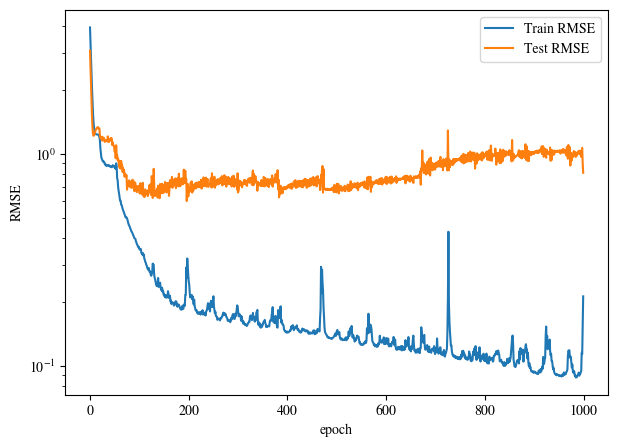

In [41]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [42]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

### Weighted Tanimoto similarity

In [43]:
def compute_tanimoto_similarity(mol1, mol2):

    # Generate fingerprints for each molecule
    fp1 = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol1, radius=4, nBits=2048)
    fp2 = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol2, radius=4, nBits=2048)

    # Compute Tanimoto similarity between the two fingerprints
    tanimoto_similarity = rdkit.DataStructs.FingerprintSimilarity(fp1, fp2)

    return tanimoto_similarity

def weighted_tanimoto(df, col_name_extrapolation, col_name_mol, n_most_similar=5):
  # get train and test counts
  df_counts_training = df[df['Split'] == 'Training'][col_name_extrapolation].value_counts(normalize=True).to_frame().rename(columns={col_name_extrapolation: 'weight'})
  df_counts_testing = df[df['Split'] == 'Testing'][col_name_extrapolation].value_counts(normalize=True).to_frame().rename(columns={col_name_extrapolation: 'weight'})

  # map molecules
  df_copy = df.copy()
  mapping_dict = df_copy.set_index(col_name_extrapolation)[col_name_mol].to_dict()

  df_counts_training['mol'] = df_counts_training.index.map(mapping_dict)
  df_counts_testing['mol'] = df_counts_testing.index.map(mapping_dict)

  # compute weighted Tanimoto similarity
  test_tanimoto_indicators = []
  for mol_test in df_counts_testing['mol'].tolist():

    tanimoto_similarity_lst = []
    weights_lst = df_counts_training['weight'].tolist()

    for mol_train in df_counts_training['mol'].tolist():
      tanimoto_similarity_lst.append(compute_tanimoto_similarity(mol_test, mol_train))

    sort_indices = np.argsort(tanimoto_similarity_lst)[::-1]
    sorted_tanimoto_similarity_lst = np.array(tanimoto_similarity_lst)[sort_indices].tolist()
    sorted_weights_lst = np.array(weights_lst)[sort_indices].tolist()

    weighted_tanimoto = np.dot(sorted_tanimoto_similarity_lst[:n_most_similar], sorted_weights_lst[:n_most_similar])
    test_tanimoto_indicators.append(weighted_tanimoto)

  df_counts_testing['Tanimoto indicator'] = test_tanimoto_indicators
  df_counts_testing.drop(columns=['weight','mol'], inplace=True)
  return df_counts_testing

In [44]:
df_test_tanimoto_indicator = weighted_tanimoto(df, 'HBA name', 'mol_hba')
df_test_tanimoto_indicator

,Tanimoto indicator
Betain,0.185484
[TBA]Cl,0.161962
[ATPP]Br,0.017285
[TEA]Br,0.097706
[TMA]Cl,0.192158
[TBP]Br,0.049966
[TEMA]Cl,0.180175
[TOMA]Br,0.127532
[TOMA]Cl,0.137838
Thymol,0.037936


In [45]:
tanimoto_indicators = test_df['HBA name'].map(df_test_tanimoto_indicator['Tanimoto indicator']).tolist()

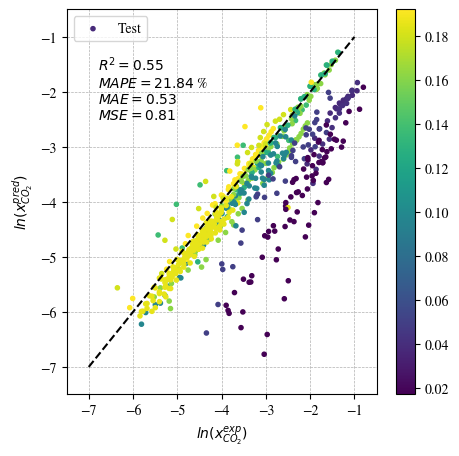

In [46]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing, color_vals=tanimoto_indicators)

## Generalization to other HBDs

In [63]:
df = df_org

In [64]:
print('Unique HBDs: ', df['HBD name'].nunique(), '\n','-'*20)
df['HBD name'].value_counts()

Unique HBDs:  26 
 --------------------


LEV                222
Guaiacol           216
DECA               167
DEG                152
1,2-propanediol    147
Phenol             132
LA                 121
HEXA               105
Imidazole           98
EG                  74
FA                  72
AC                  70
TEG                 62
EA                  51
2,3-butanediol      40
1,4-butanediol      40
Urea                36
MDA                 29
1,2-butanediol      28
1,2,4-triazole      28
ECN                 21
GLY                 17
Thymol              16
2,6-xylenol         16
DEA                  7
OCTA                 6
Name: HBD name, dtype: int64

In [65]:
df = split_edge(df, 0.3, 'HBD name', random_seed=0)
df['Split'].value_counts(normalize=True)

Training    0.704004
Testing     0.295996
Name: Split, dtype: float64

In [66]:
df_HBD_counts_training = df[df['Split'] == 'Training']['HBD name'].value_counts(normalize=True)
df_HBD_counts_training

LEV                0.159827
DECA               0.120230
DEG                0.109431
1,2-propanediol    0.105832
Phenol             0.095032
LA                 0.087113
Imidazole          0.070554
FA                 0.051836
AC                 0.050396
1,4-butanediol     0.028798
MDA                0.020878
1,2-butanediol     0.020158
1,2,4-triazole     0.020158
ECN                0.015119
GLY                0.012239
Thymol             0.011519
2,6-xylenol        0.011519
DEA                0.005040
OCTA               0.004320
Name: HBD name, dtype: float64

In [67]:
df_HBD_counts_testing = df[df['Split'] == 'Testing']['HBD name'].value_counts(normalize=True)
df_HBD_counts_testing

Guaiacol          0.369863
HEXA              0.179795
EG                0.126712
TEG               0.106164
EA                0.087329
2,3-butanediol    0.068493
Urea              0.061644
Name: HBD name, dtype: float64

#### Normalizing data

In [68]:
train_df = df[df['Split'] == 'Training'].copy()
test_df = df[df['Split'] == 'Testing'].copy()

# Extract features and target
features = ['T (K)', 'P (kPa)', 'r HBA', 'r HBD', 'ap_hba', 'ap_hbd', 'bp_hba',
            'bp_hbd', 'topopsa_hba', 'topopsa_hbd', 'hb_hba', 'hb_hbd', 'inter_hb']
X_train = train_df[features].values
y_train = train_df['ln(x)-experimental'].values
X_test = test_df[features].values
y_test = test_df['ln(x)-experimental'].values

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Add normalized features back to the original DataFrame
norm_feature_names = ['T_norm', 'P_norm', 'r_HBA_norm', 'r_HBD_norm', 'ap_hba_norm', 'ap_hbd_norm', 'bp_hba_norm',
            'bp_hbd_norm', 'topopsa_hba_norm', 'topopsa_hbd_norm', 'hb_hba_norm', 'hb_hbd_norm', 'inter_hb_norm']
train_df[norm_feature_names] = X_train_norm
test_df[norm_feature_names] = X_test_norm

# Combine the training and testing dataframes
df = pd.concat([train_df, test_df])

# to preserve the original order
df = df.sort_index()

#### Create graphs

In [69]:
g_hba_lst, g_hbd_lst = sys2graph(df, 'mol_hba', 'mol_hbd', 'ln(x)-experimental')
df['g_hba'] = g_hba_lst
df['g_hbd'] = g_hbd_lst

#### Dataloaders

In [70]:
train_df = df[df['Split'] == 'Training']
test_df = df[df['Split'] == 'Testing']

train_dataloader = get_dataloader_pairs(train_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)
test_dataloader = get_dataloader_pairs(test_df, 'g_hba', 'g_hbd', batch_size=32, shuffle=False, drop_last=False)

#### Train GNN

In [71]:
model_name = 'GNN_edge_HBD'

model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0006031500598155615)

In [72]:
train_loss_save, test_loss_save = [], []
pbar = tqdm(range(epochs))
for epoch in pbar:
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

    pbar.set_postfix(train_loss=train_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           f'{model_name}.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

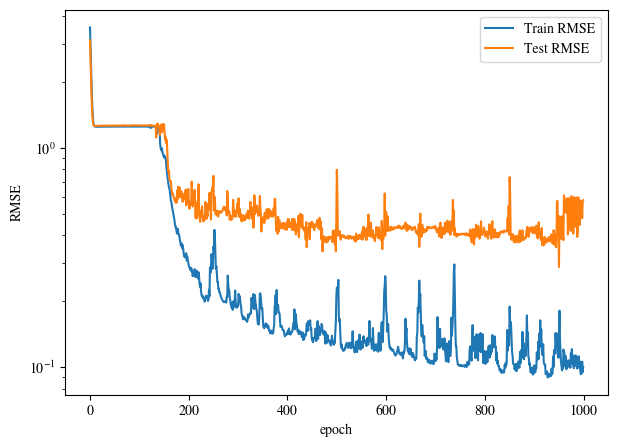

In [73]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [74]:
model = GHGNN(n_atom_features(), n_bond_features(), 3, 25, 4).to(device)
checkpoint = torch.load(f'{model_name}.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for batch_c1, batch_c2 in dataloader:
      X1 = batch_c1
      X2 = batch_c2
      X1, X2 = X1.to(device), X2.to(device)
      y_hat = model(X1, X2).cpu().numpy().tolist()
      y_storage.extend(y_hat)

### Weighted Tanimoto similarity

In [75]:
df_test_tanimoto_indicator = weighted_tanimoto(df, 'HBD name', 'mol_hbd')
df_test_tanimoto_indicator

,Tanimoto indicator
Guaiacol,0.037147
HEXA,0.157810
EG,0.056011
TEG,0.083140
EA,0.046636
"2,3-butanediol",0.093865
Urea,0.072522


In [76]:
tanimoto_indicators = test_df['HBD name'].map(df_test_tanimoto_indicator['Tanimoto indicator']).tolist()

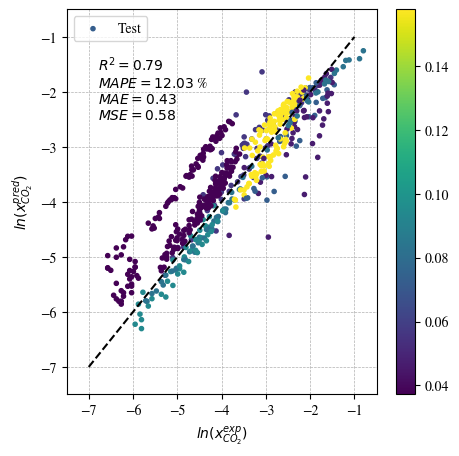

In [77]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing, color_vals=tanimoto_indicators)